# RCFM Model

## 1. Import modules and helper functions

In [1]:
# Modules
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy.optimize import curve_fit

# Helper functions from DataAid.py and DataImport.py
import DataAid
import DataImporter

# Numerically stable class of functions from Neros_v2.py
import Neros_v4

## 2. Load Galaxy Data

In [2]:
# Load Galaxy Data
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
sparc128Galaxies = DataAid.GetGalaxyData("data/Sparc/SparcSubset135/")
littleDataGalaxies = DataAid.GetGalaxyData("data/little-data-things/data/")
lcmGalaxies = DataAid.GetGalaxyData("data/LCMFits/data/")

# Load Milky Way Model Data
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")
mcGaughMW = DataAid.GetGalaxyData("data/McGaugh/")

# Create array of Milky Way radius and vlum tuples from model data
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])
MWMcGaugh = np.array(mcGaughMW['MW_lumMcGaugh'])


## 3. Create Neros class instance

In [3]:
# Create Neros instance to perform calculations with the supplied Milky Way model as comparison
# Change Milky Way model by changing the variable in the parentheses
# i.e. neros_fns = Neros_v2.Neros(MWModelVariable)

neros_fns = Neros_v4.Neros(MWXueSofue)
MW_name = "XueSofue" # Change this if you change the MW model in neros_fns!
MW_rad = neros_fns.mw_rad
MW_vLum = neros_fns.mw_vLum
#MW_phi = neros_fns.mw_phi

MW_vLum_interp_func = neros_fns.mw_vLum_interp

## 4. Designate outfile name, initialize variables, and designate galaxy sample

In [4]:
# This designates which galaxy sample to fit
galaxies = lcmGalaxies


## 5. Fit galaxies, print and save graphs

/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC3198_deBlok
chi_squared is: 1.395070438213474
alpha is: 188.0031904481162
disk_scale is: 1.206889554409153
bulge_scale is: 1.0
phi_zero is: 3.694658858819989e-06
--------------------------
Running average chi_squared: 1.395070438213474
galaxyName is: NGC2841_deBlokTHINGS
chi_squared is: 1.3063860500096636
alpha is: 22.049366053691376
disk_scale is: 1.3402202753646881
bulge_scale is: 1.1806625623166718
phi_zero is: 4.300785293848209e-06
--------------------------
Running average chi_squared: 1.3507282441115689
galaxyName is: NGC7814_Fraternalli
chi_squared is: 0.17009149150568412
alpha is: 9.87262179737908
disk_scale is: 0.6669334998219786
bulge_scale is: 1.0623482856517408
phi_zero is: 3.4685488224002466e-06
--------------------------
Running average chi_squared: 0.9571826599096073


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC4088_rotmod-Copy1
chi_squared is: 0.38621046243136076
alpha is: 149.42109451778222
disk_scale is: 0.6585167791154707
bulge_scale is: 1.0
phi_zero is: 3.1919951620190414e-06
--------------------------
Running average chi_squared: 0.8144396105400457


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC7793_GentileTaM
chi_squared is: 4.173623302788816
alpha is: 1192.8767845884304
disk_scale is: 1.1856950159460993
bulge_scale is: 1.0
phi_zero is: 4.081926881990854e-06
--------------------------
Running average chi_squared: 1.4862763489897997


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC2403_deBlokThings
chi_squared is: 1.2867002080689685
alpha is: 372.43784774875337
disk_scale is: 1.3445572186931087
bulge_scale is: 1.0
phi_zero is: 4.432909492450046e-06
--------------------------
Running average chi_squared: 1.4530136588363278


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC3198_GentileMaria
chi_squared is: 1.927568169160115
alpha is: 135.21599221046336
disk_scale is: 1.599089599436129
bulge_scale is: 1.0
phi_zero is: 3.664487332755443e-06
--------------------------
Running average chi_squared: 1.5208071603111544


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC5907_rotmod-Copy1
chi_squared is: 4.41853396180498
alpha is: 60.28674481222384
disk_scale is: 0.9935340186949387
bulge_scale is: 1.0
phi_zero is: 3.4926067951406126e-06
--------------------------
Running average chi_squared: 1.8830230104978827


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: F563_1McGaugh
chi_squared is: 0.13167845981242854
alpha is: 267.1097879044988
disk_scale is: 1.6075307815430255
bulge_scale is: 1.0
phi_zero is: 3.392034252601659e-06
--------------------------
Running average chi_squared: 1.6884291715328323


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC3726_rotmod-Copy1
chi_squared is: 1.3856035841229408
alpha is: 235.81695774351078
disk_scale is: 0.795394681139895
bulge_scale is: 1.0
phi_zero is: 3.1919951620190414e-06
--------------------------
Running average chi_squared: 1.6581466127918432


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC3521_GentileTaM
chi_squared is: 0.7095404037733264
alpha is: 23.954507012103363
disk_scale is: 1.1320869503772812
bulge_scale is: 1.0
phi_zero is: 3.856421041674189e-06
--------------------------
Running average chi_squared: 1.5719096846992506
galaxyName is: NGC4138_rotmod-Copy1
chi_squared is: 0.7305801558492729
alpha is: 43.46758032002356
disk_scale is: 1.032297013560263
bulge_scale is: 0.00017046595676777716
phi_zero is: 2.7697701267296215e-06
--------------------------
Running average chi_squared: 1.5017988906284192


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: UGC07524_rotmod-Copy1
chi_squared is: 1.170817576528495
alpha is: 1420.8304242806948
disk_scale is: 1.4871179349196673
bulge_scale is: 1.0
phi_zero is: 3.7727107017916375e-06
--------------------------
Running average chi_squared: 1.4763387895438098


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC3953_rotmod-Copy1
chi_squared is: 0.4487340920218001
alpha is: 23.406287340026736
disk_scale is: 0.9051834212430115
bulge_scale is: 1.0
phi_zero is: 2.8647946796093216e-06
--------------------------
Running average chi_squared: 1.4029384540065235
galaxyName is: UGC08490_rotmod-Copy1
chi_squared is: 1.0141953585971668
alpha is: 415.1292914703908
disk_scale is: 1.436983660179104
bulge_scale is: 1.0
phi_zero is: 3.7576123992122394e-06
--------------------------
Running average chi_squared: 1.3770222476458998


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC2403_Botteman_LCM
chi_squared is: 3.052217049617488
alpha is: 290.4985562279692
disk_scale is: 0.9712735346122399
bulge_scale is: 1.0
phi_zero is: 3.7969748397395277e-06
--------------------------
Running average chi_squared: 1.481721922769124


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: F563_1deBlok
chi_squared is: 0.1481346089962911
alpha is: 510.51671496931766
disk_scale is: 2.5494158284826844
bulge_scale is: 1.0
phi_zero is: 3.392034252601659e-06
--------------------------
Running average chi_squared: 1.4032756101942514


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC2903_Gentile TaM
chi_squared is: 1.9541152331238743
alpha is: 74.21938219963594
disk_scale is: 1.2128025302877514
bulge_scale is: 1.0
phi_zero is: 4.15916482921319e-06
--------------------------
Running average chi_squared: 1.4338778114681194
galaxyName is: NGC7331_GentileTaM
chi_squared is: 15.993363730723226
alpha is: 87.2169929746578
disk_scale is: 0.8004830910694061
bulge_scale is: 1.572614023281589
phi_zero is: 3.877713734514092e-06
--------------------------
Running average chi_squared: 2.2001665440604934


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC5055_deBlok-lcmEdit5
chi_squared is: 0.5860960960647615
alpha is: 18.462440811001102
disk_scale is: 1.1768129141036576
bulge_scale is: 1.0
phi_zero is: 4.231216280710444e-06
--------------------------
Running average chi_squared: 2.119463021660707


<ipython-input-5-cb5fc31712c6>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, figsize = (15, 15))
/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC2903 deBlok
chi_squared is: 2.533036407529066
alpha is: 59.558522889873366
disk_scale is: 2.069575249415443
bulge_scale is: 1.0
phi_zero is: 4.190957322721796e-06
--------------------------
Running average chi_squared: 2.139156992416343
galaxyName is: NGC6946_deBlok_TH
chi_squared is: 1.203045154368878
alpha is: 72.0670213295124
disk_scale is: 0.8473521582690475
bulge_scale is: 0.9281427291583743
phi_zero is: 4.398735132553434e-06
--------------------------
Running average chi_squared: 2.0966064543232767


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC5055_deBlok-lcmEdit6
chi_squared is: 0.574579556221015
alpha is: 18.49117244444448
disk_scale is: 1.1763527082959455
bulge_scale is: 1.0
phi_zero is: 4.231216280710444e-06
--------------------------
Running average chi_squared: 2.0304313717970914


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC2915_San96
chi_squared is: 2.201216759667632
alpha is: 175.5068222715632
disk_scale is: 1.096104691595076
bulge_scale is: 1.0
phi_zero is: 3.5327821976478137e-06
--------------------------
Running average chi_squared: 2.0375474296250307
galaxyName is: NGC5055_deBlok
chi_squared is: 1.588340106578765
alpha is: 22.35971847154564
disk_scale is: 0.83725855090351
bulge_scale is: 2.0529336210923006
phi_zero is: 4.233511539659199e-06
--------------------------
Running average chi_squared: 2.01957913670318


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC3992_rotmod-Copy1
chi_squared is: 0.7043886789756866
alpha is: 60.29842452842872
disk_scale is: 1.0801188027922466
bulge_scale is: 1.0
phi_zero is: 2.9716371906492047e-06
--------------------------
Running average chi_squared: 1.9689948883290458


/Users/sophiacisneros/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


galaxyName is: NGC7793_DicaireISO
chi_squared is: 0.39008451423800933
alpha is: 233.59862185926855
disk_scale is: 1.053050057694776
bulge_scale is: 1.0
phi_zero is: 3.92843299916819e-06
--------------------------
Running average chi_squared: 1.9105167263256742
galaxyName is: NGC0891_rotmod-Copy1
chi_squared is: 5.697872364057578
alpha is: 34.55856550230176
disk_scale is: 0.5843029142118124
bulge_scale is: 0.7864101706110433
phi_zero is: 3.4685488224002466e-06
--------------------------
Running average chi_squared: 2.045779427673242


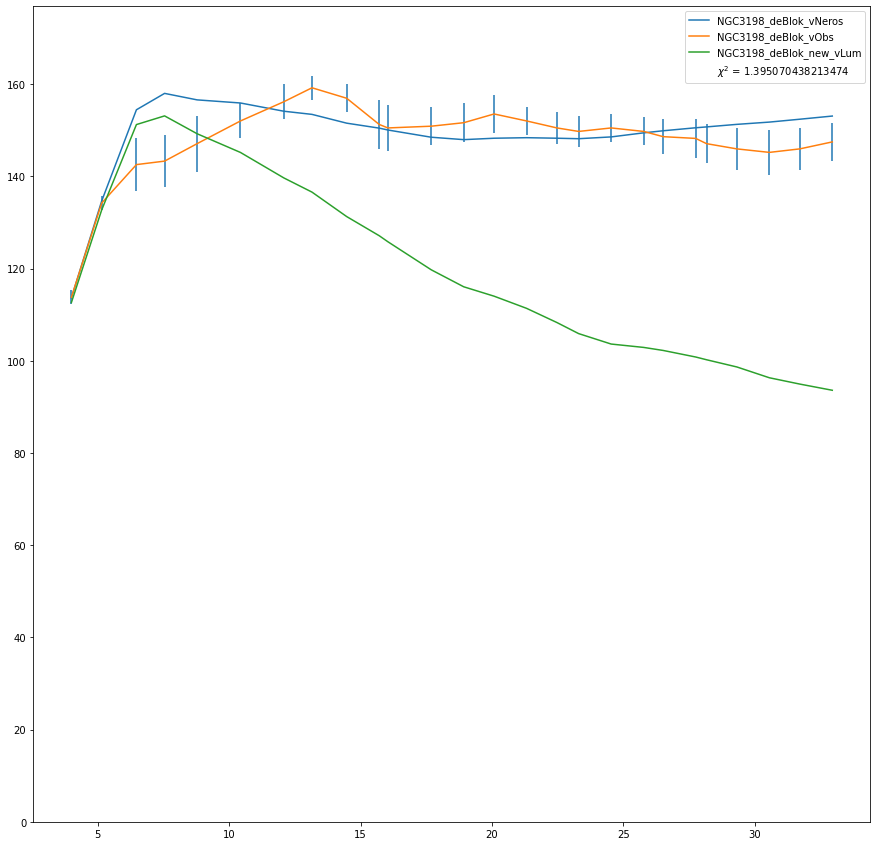

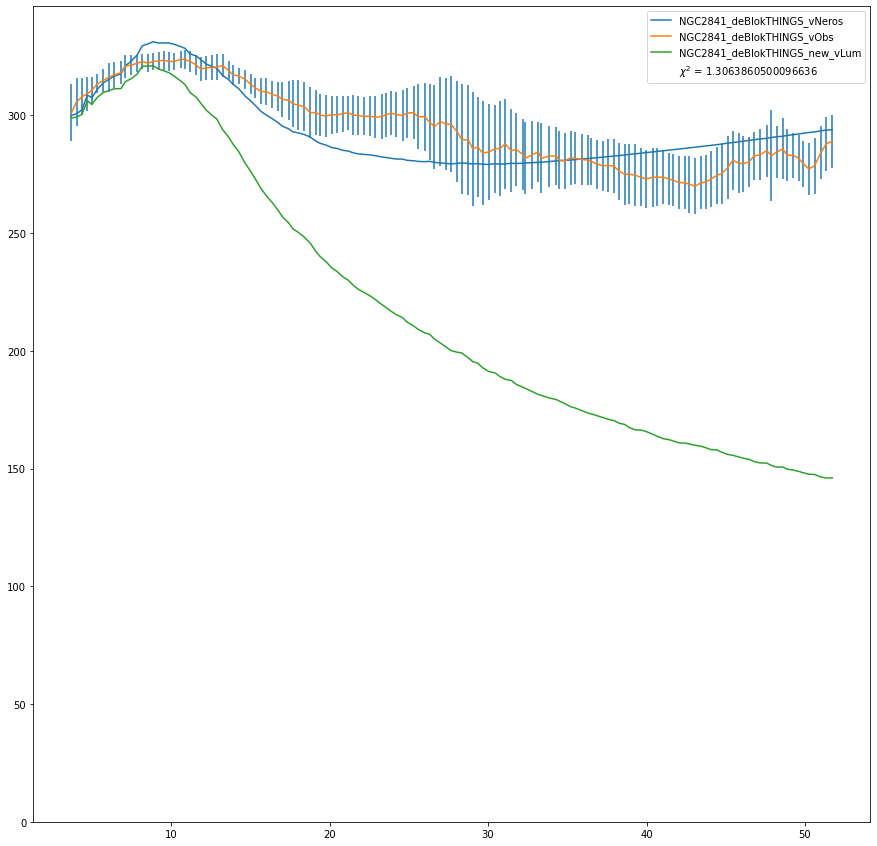

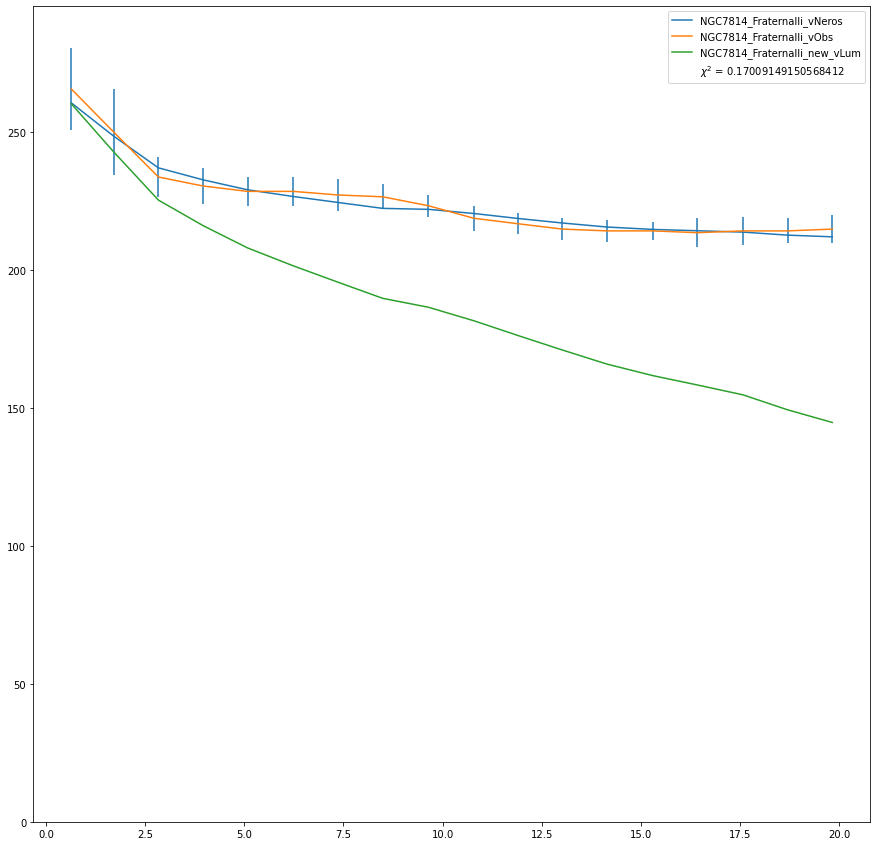

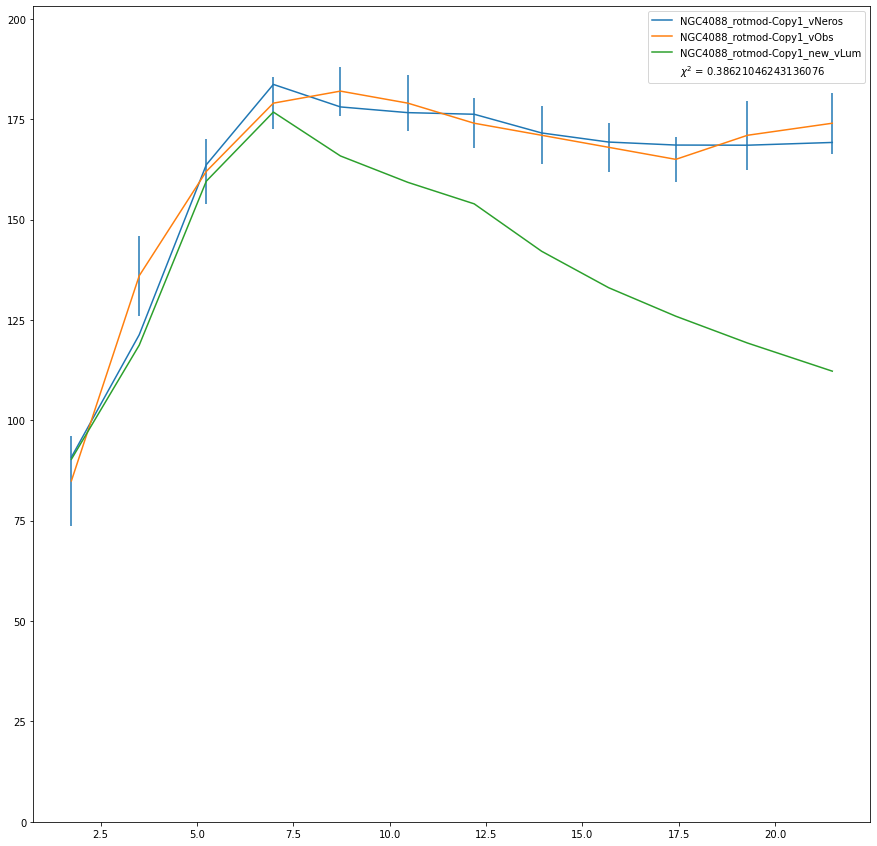

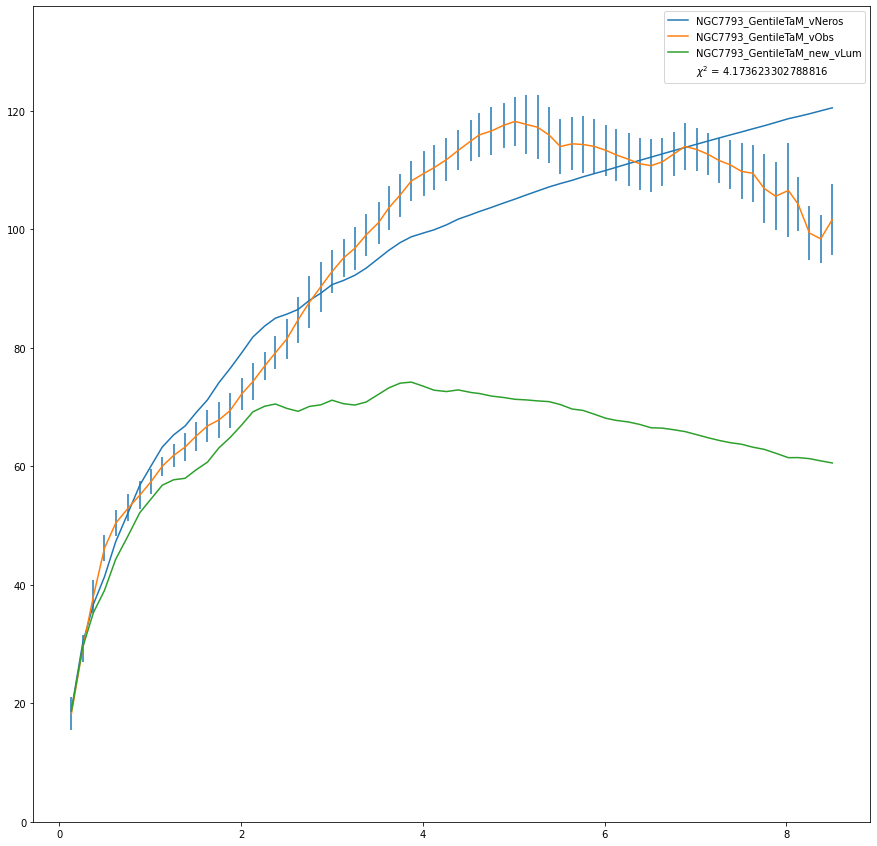

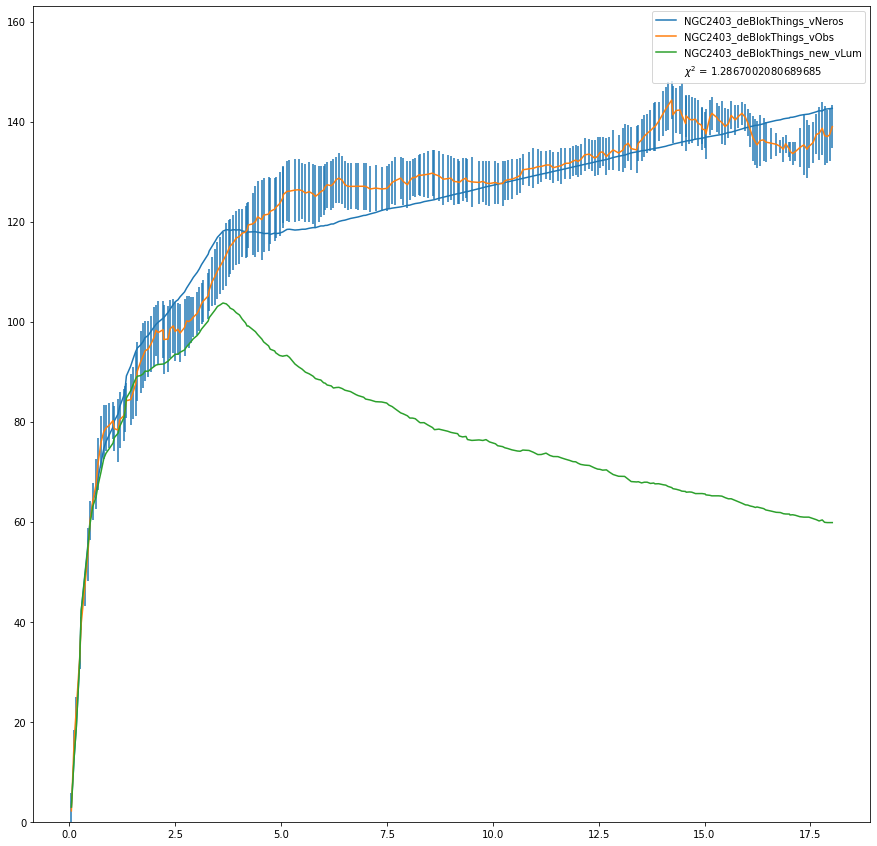

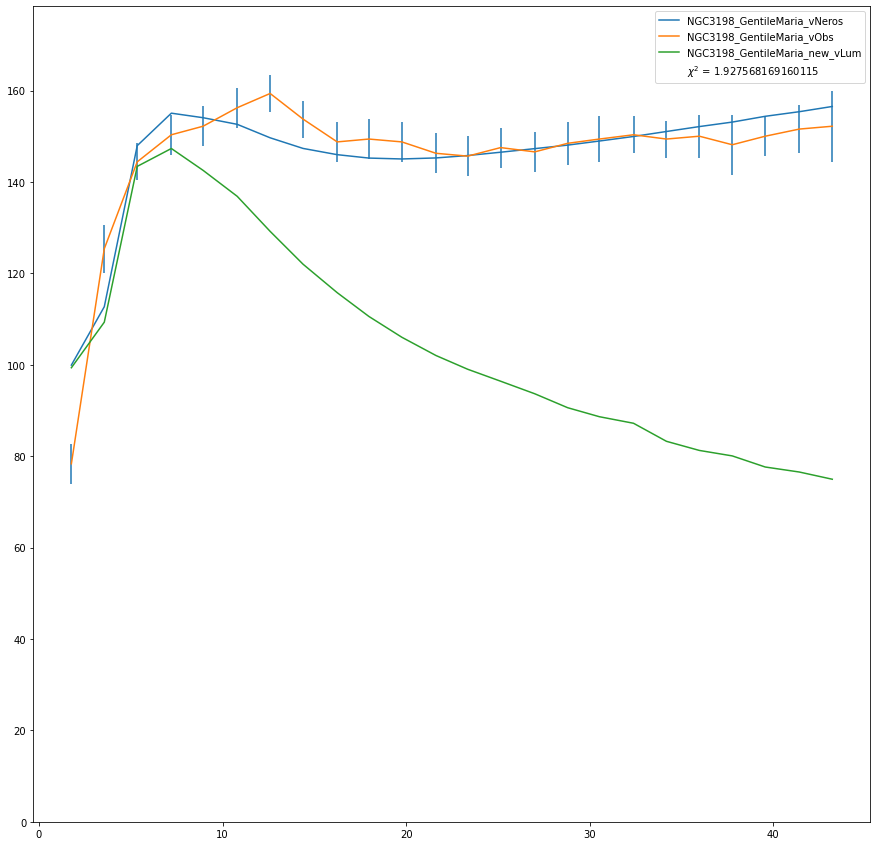

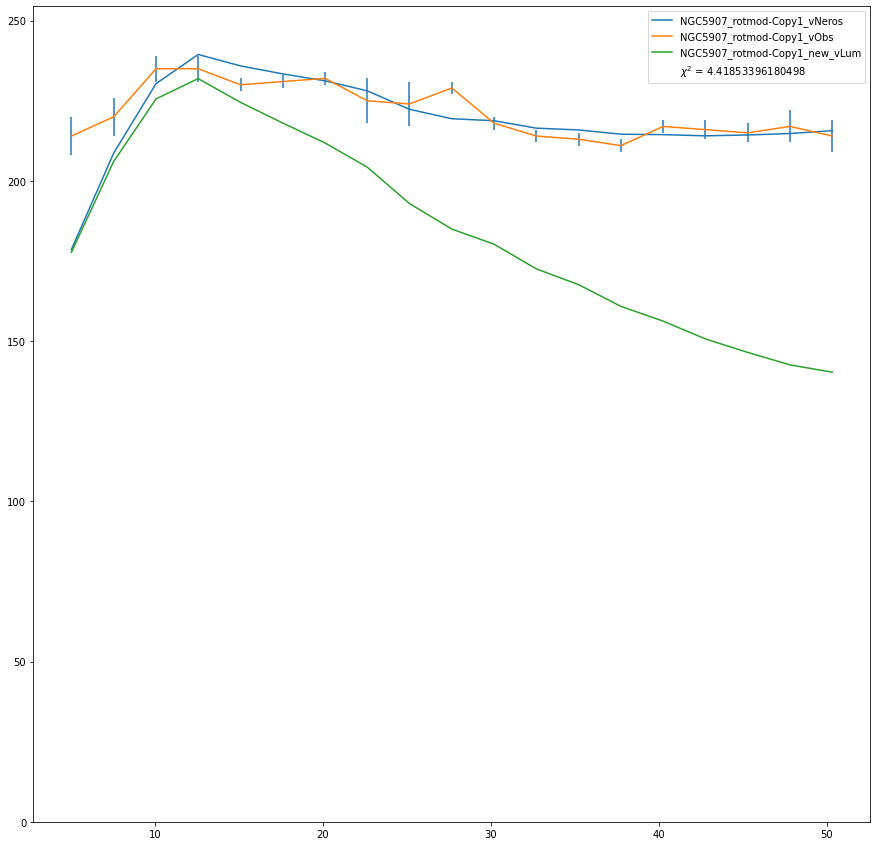

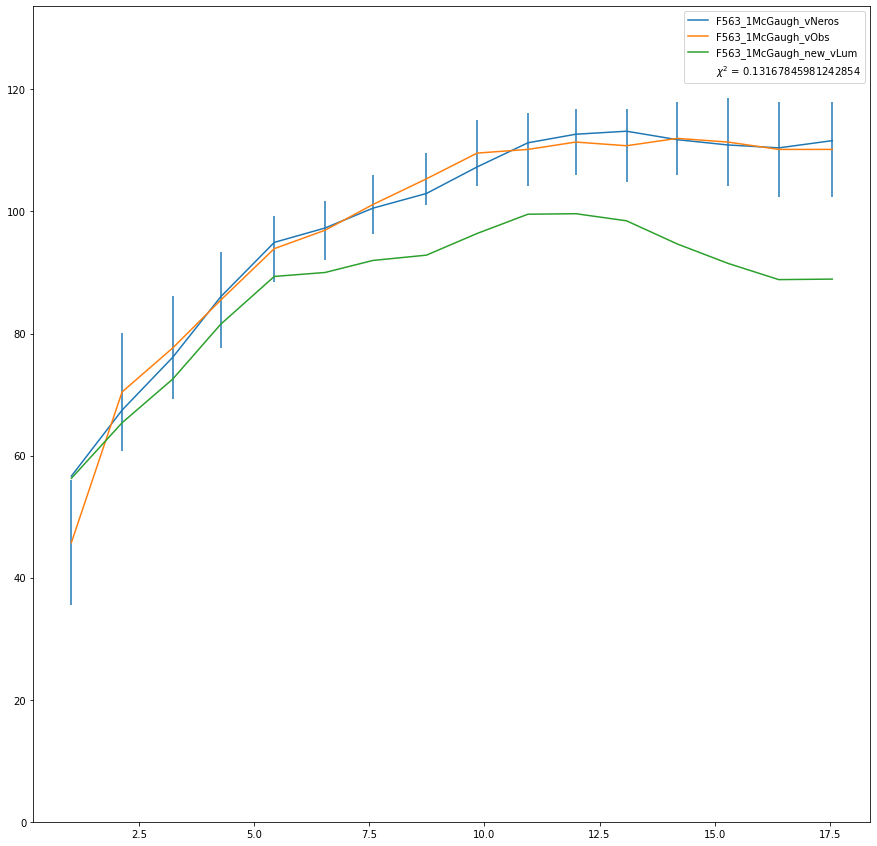

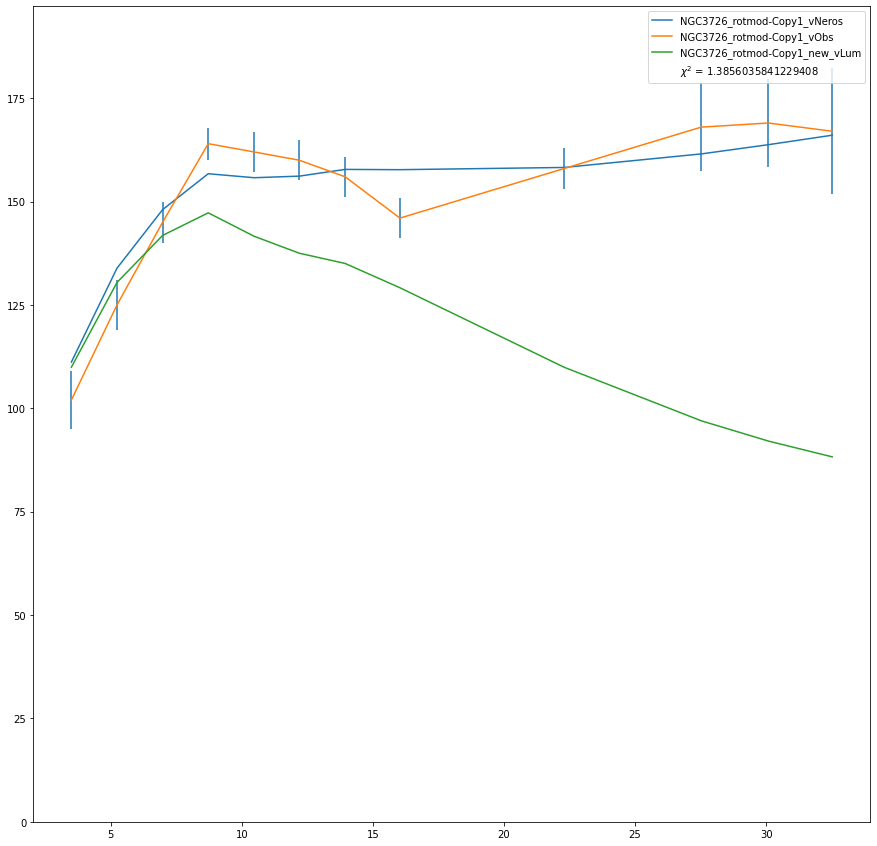

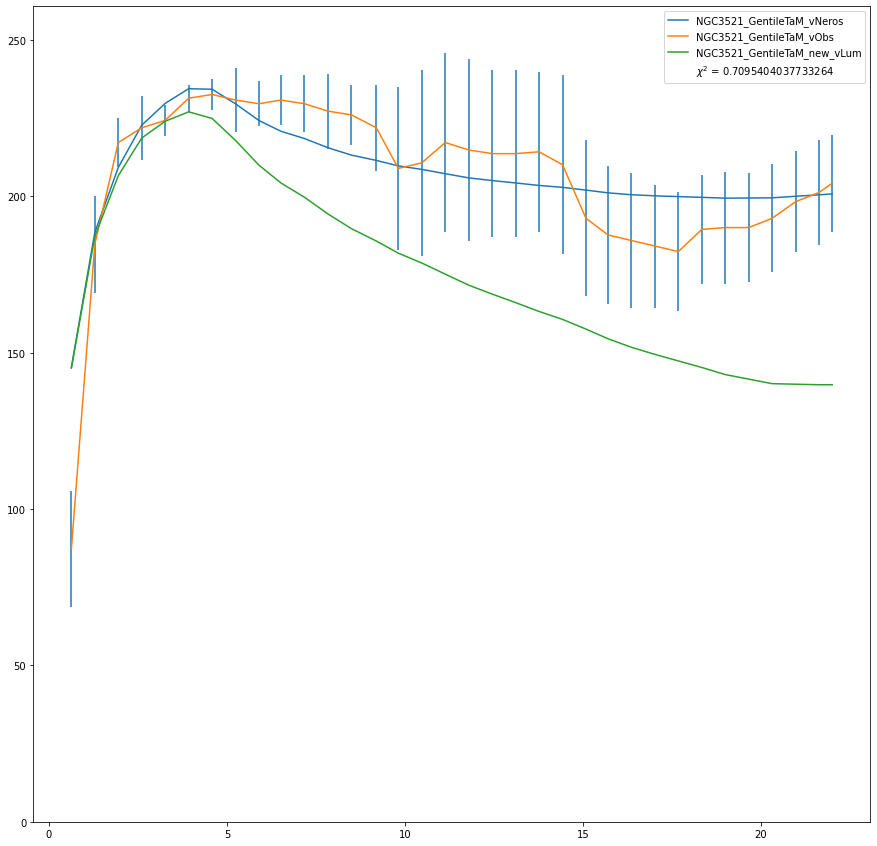

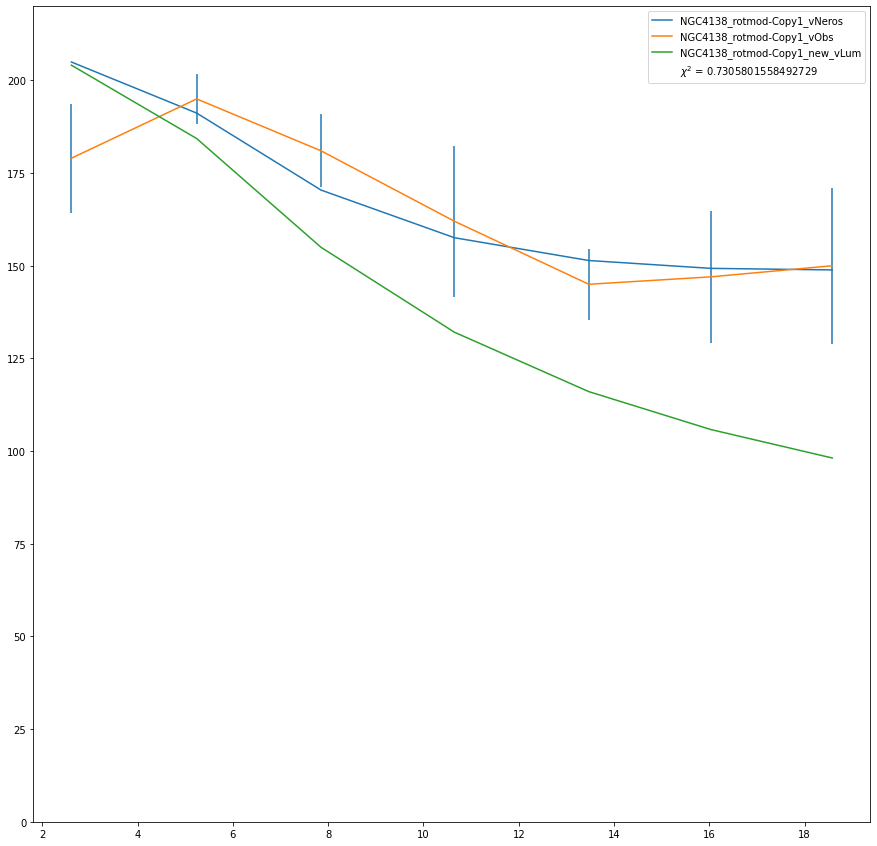

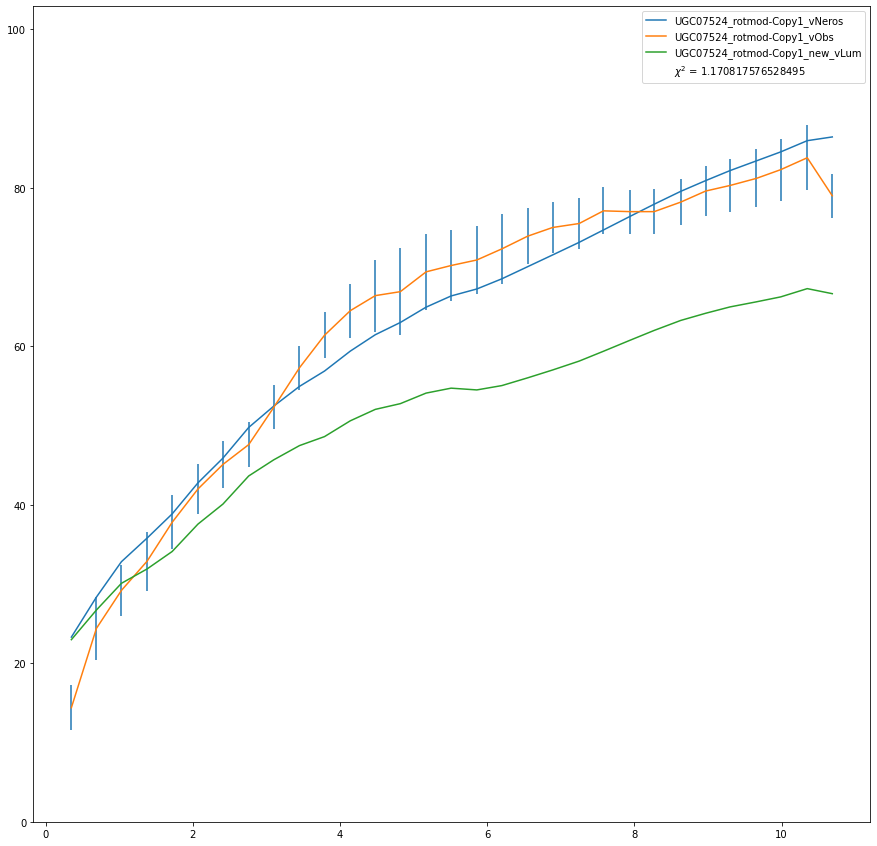

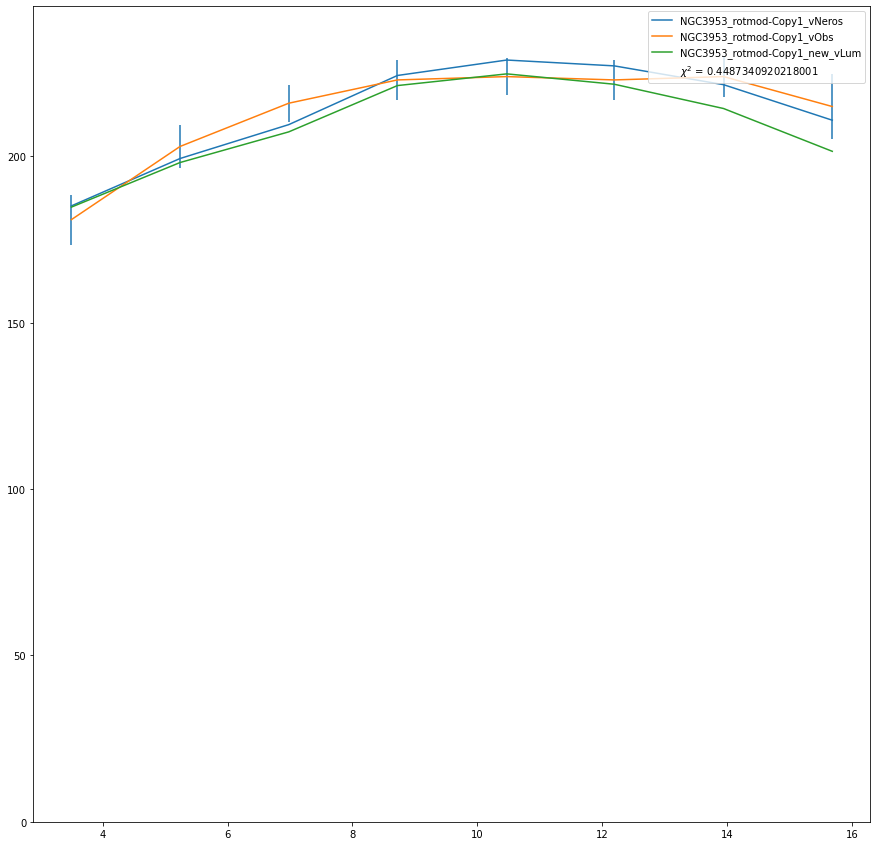

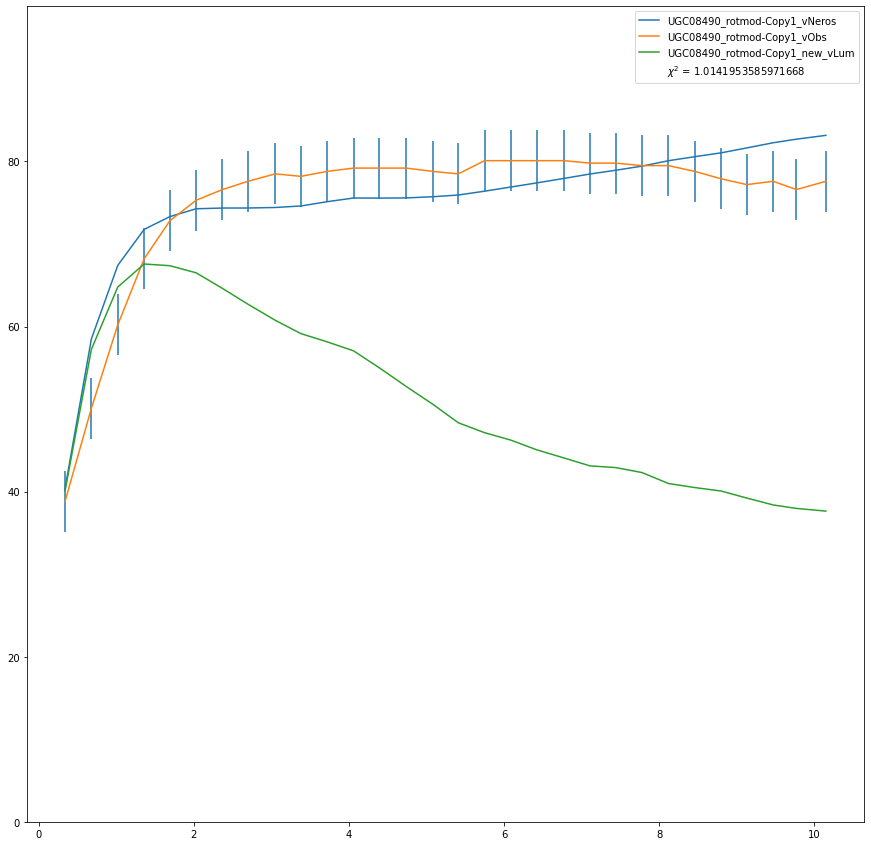

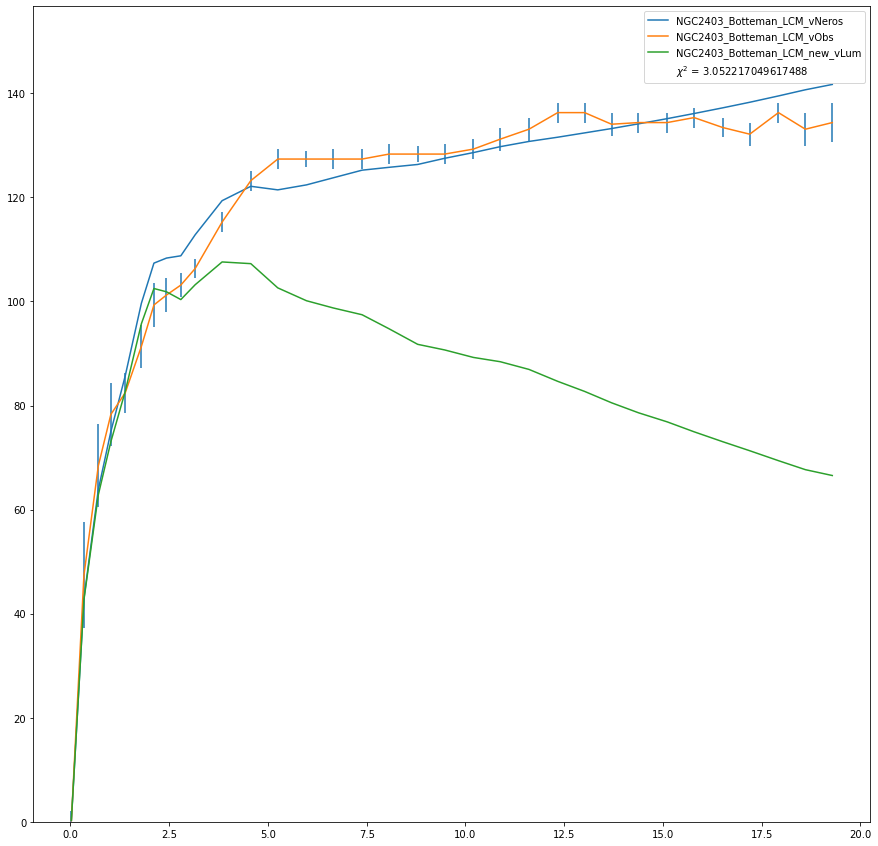

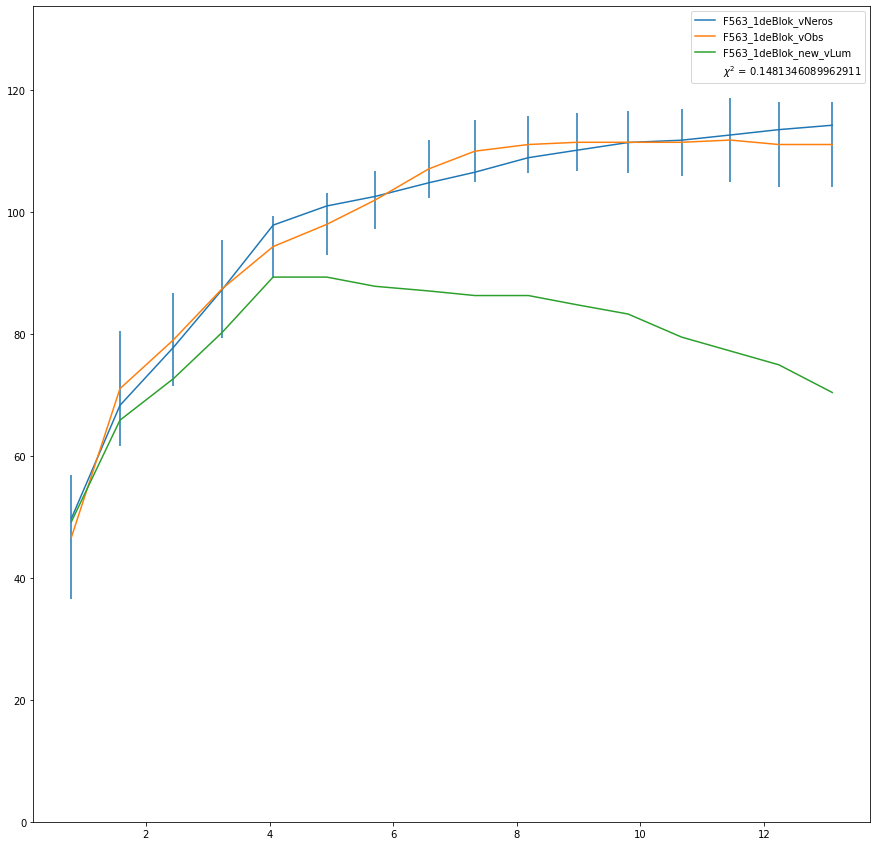

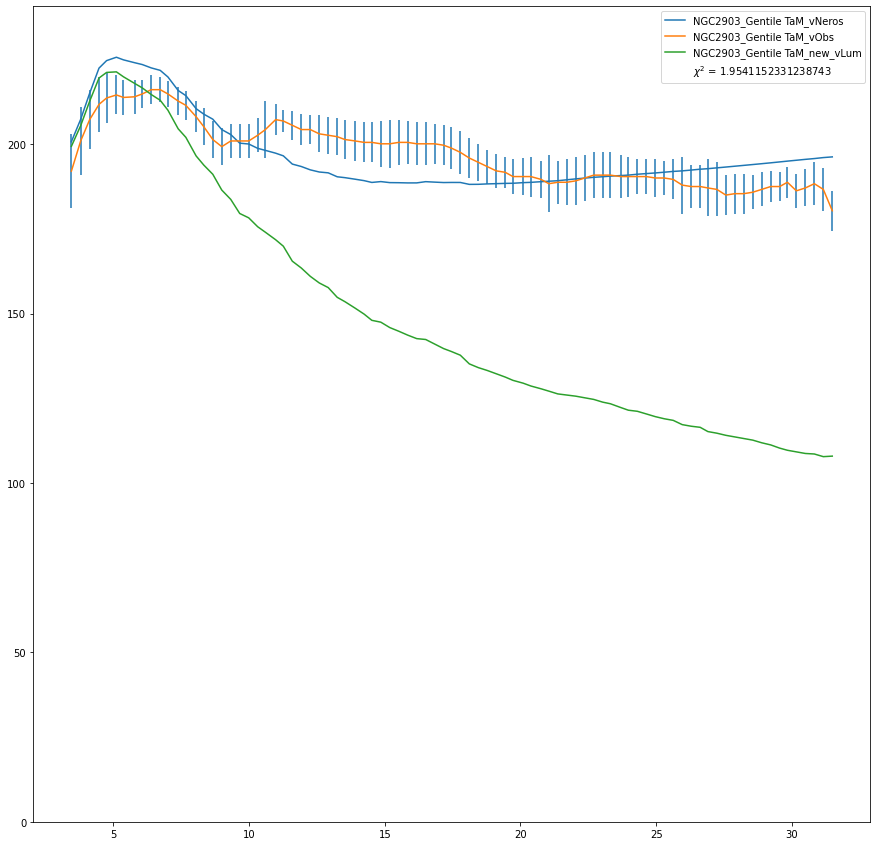

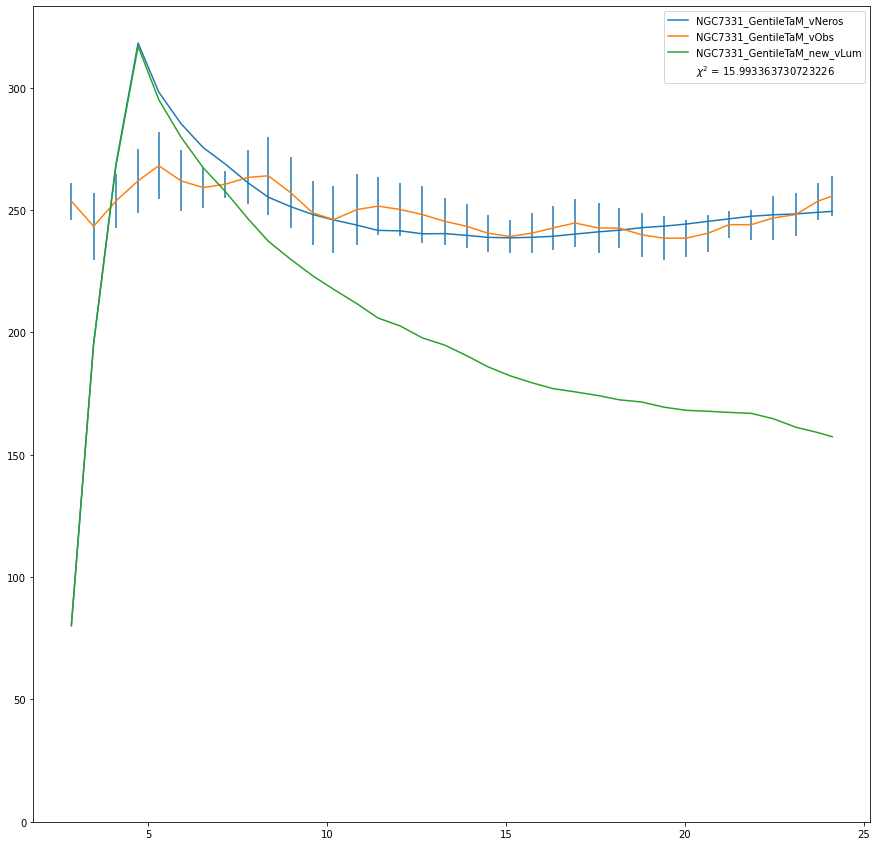

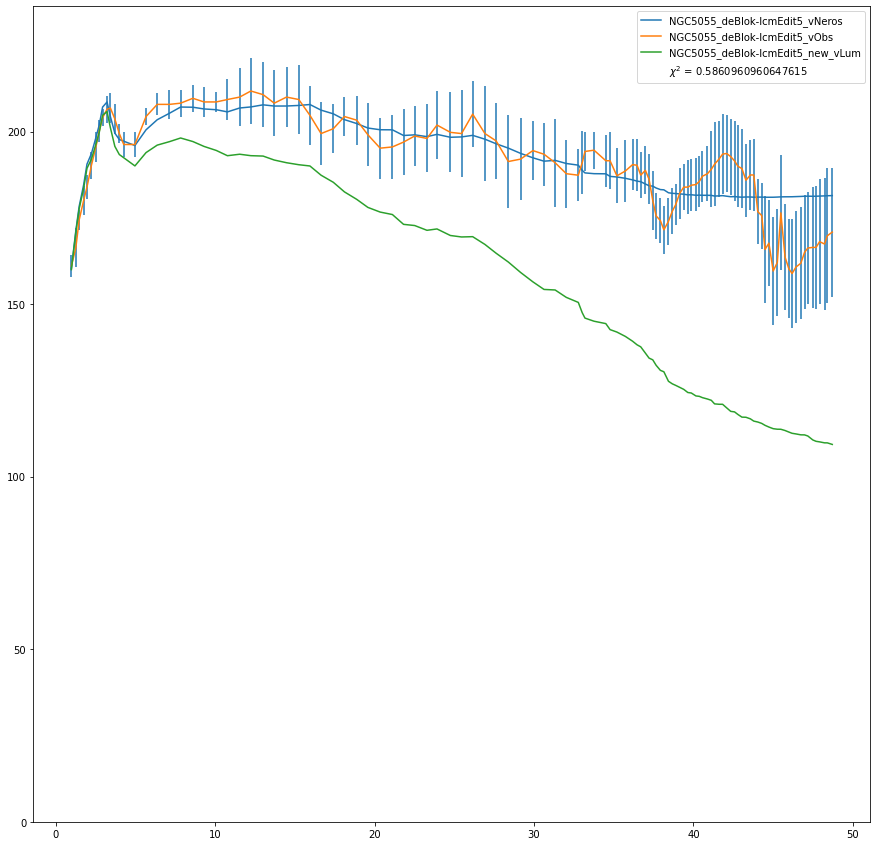

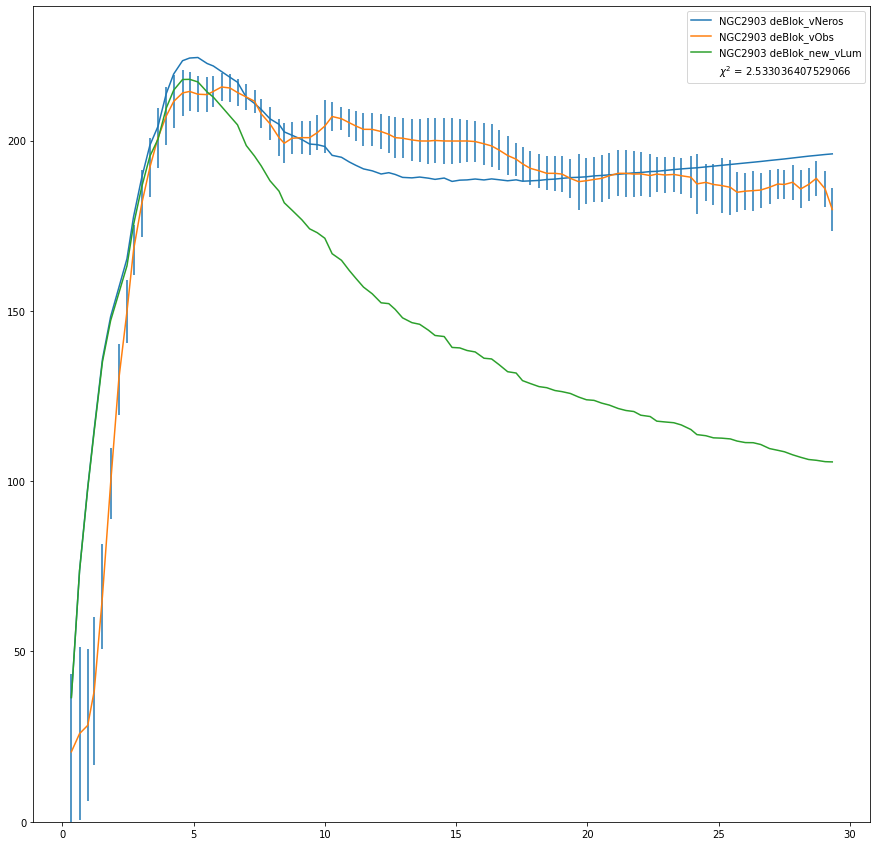

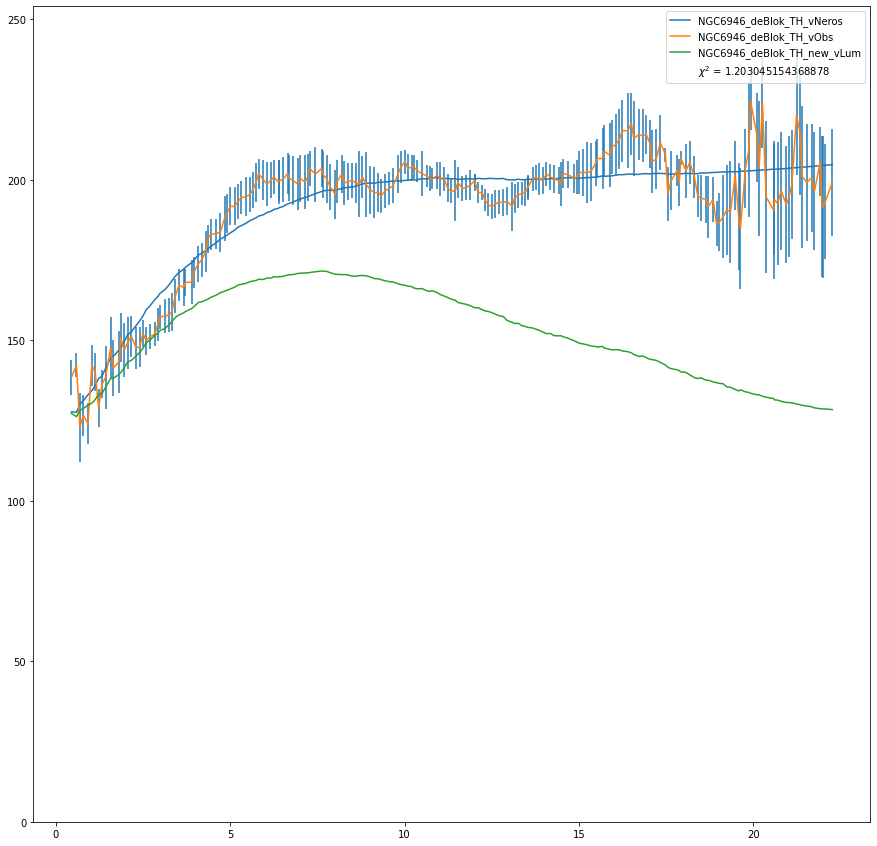

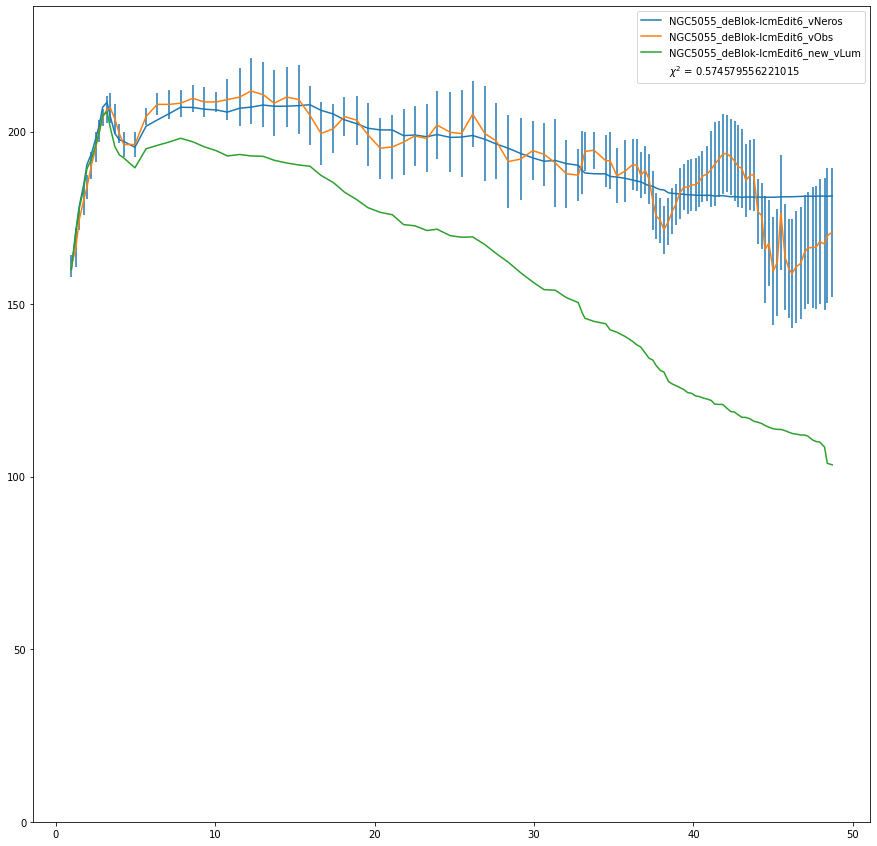

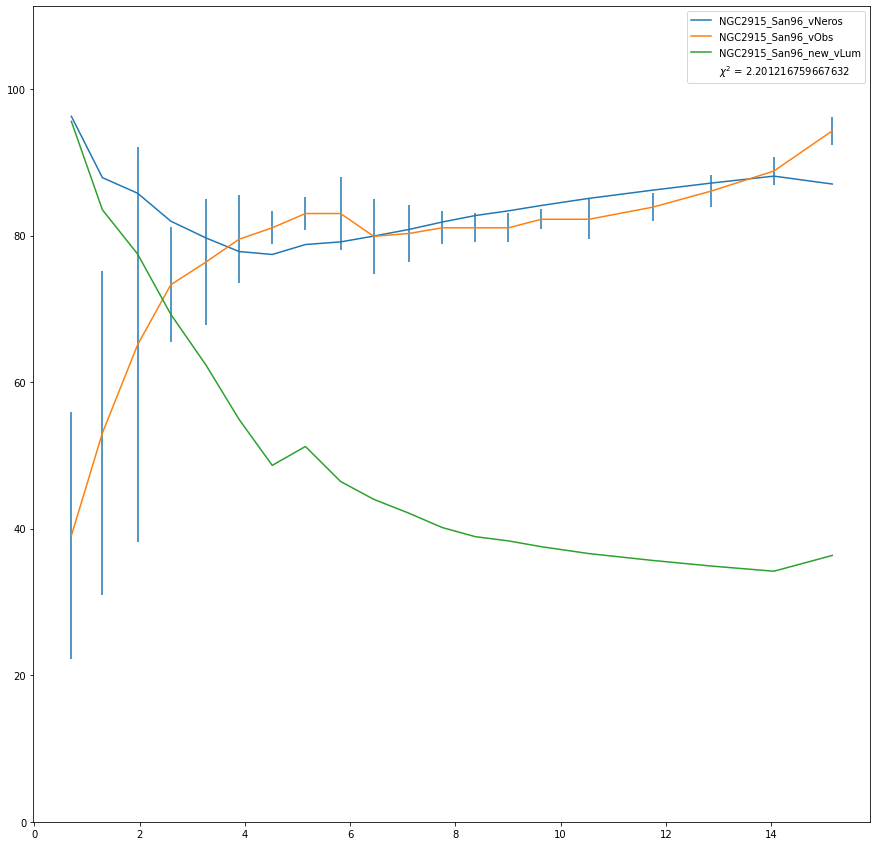

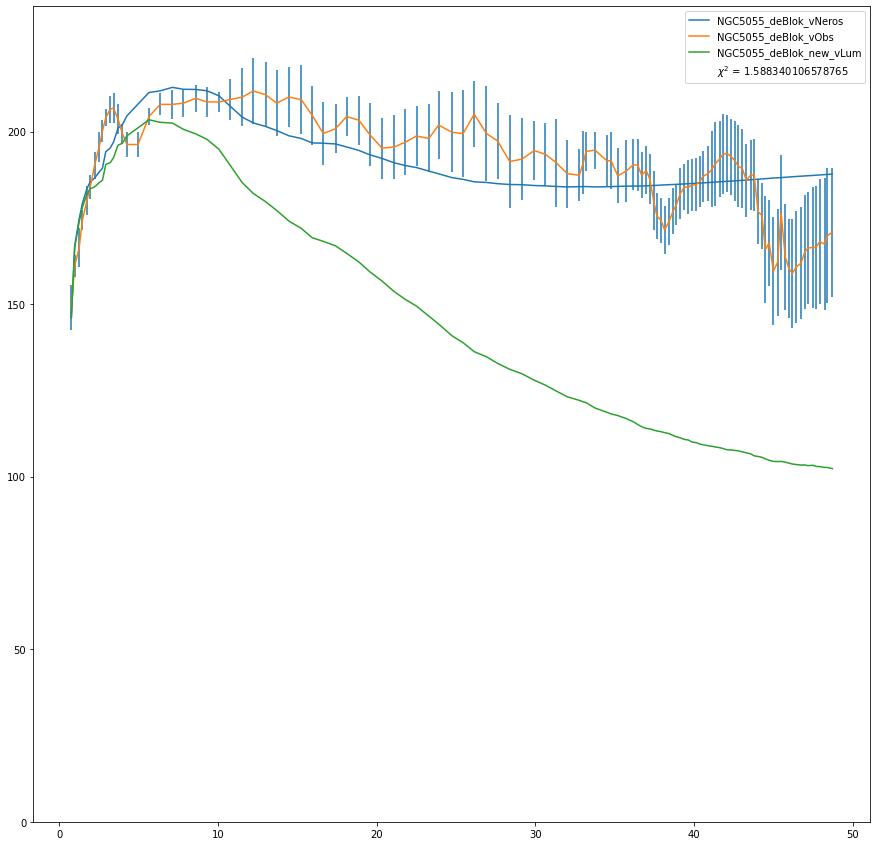

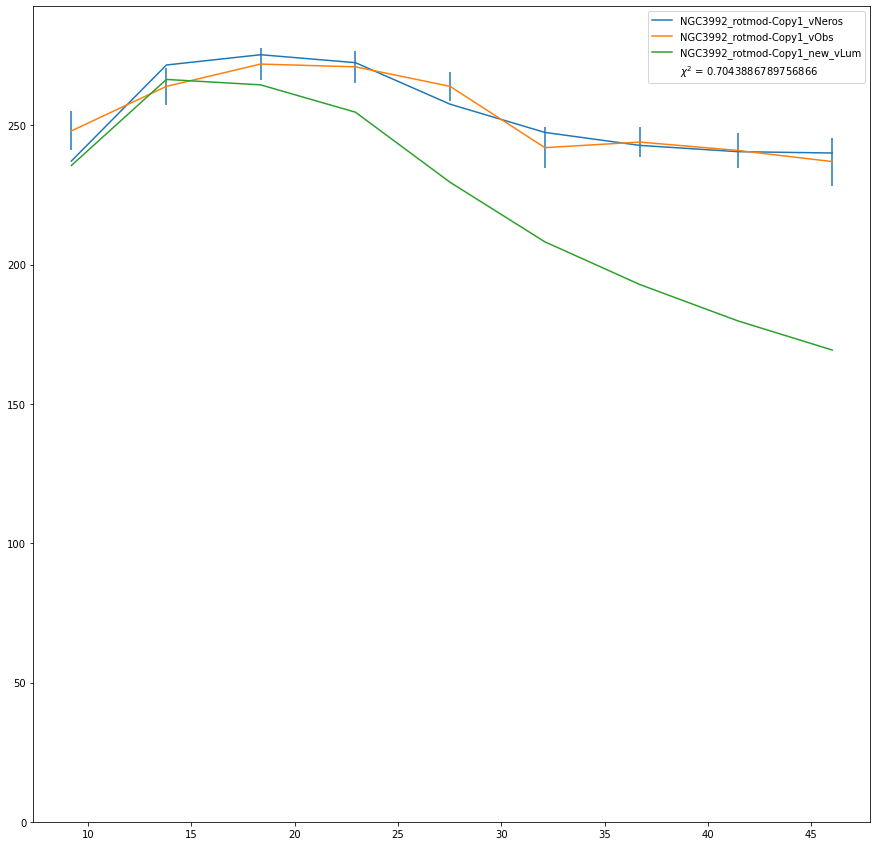

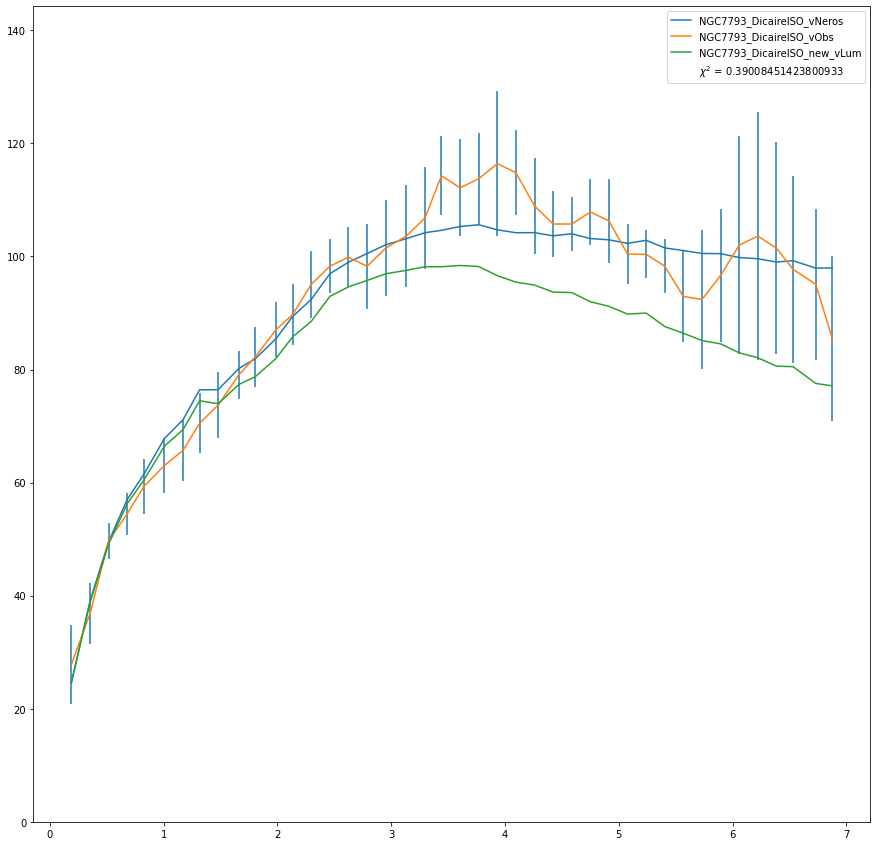

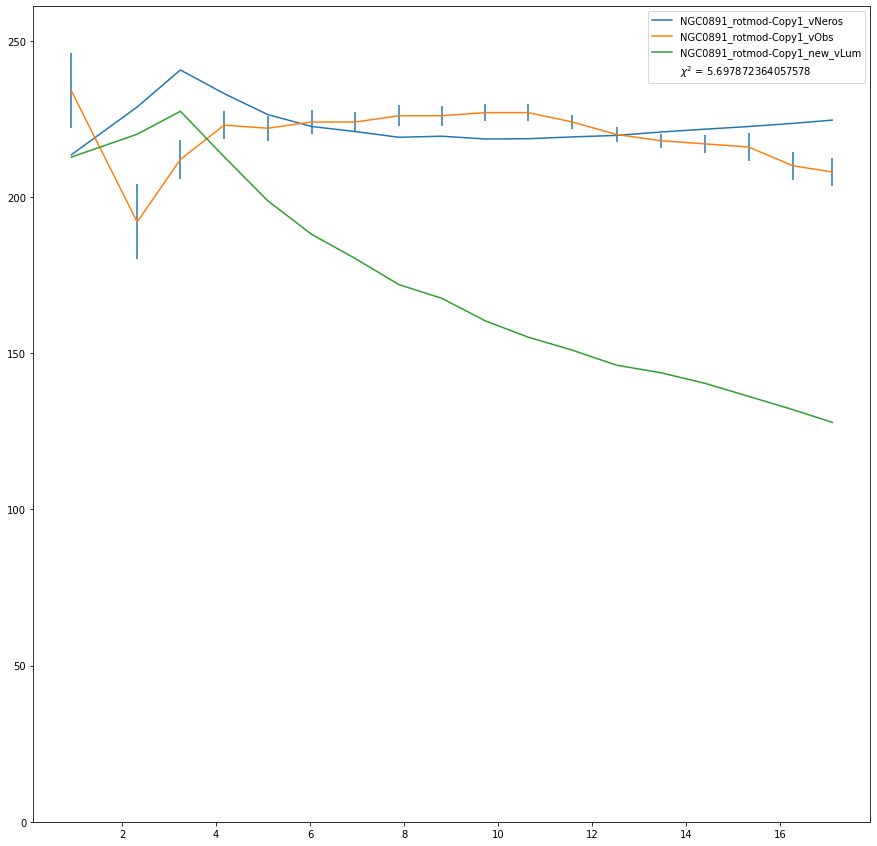

In [5]:
"""
This is the main body of the model. 
It loops through galaxies in the designated sample,
it calculates vLCM, vNeros, and chiSquared,
it fits galaxy data using alpha and vLumFreeParam,
it prints the values of alpha and vLumFreeParam to the console,
and it saves the graphs to a file.
"""

# This is where the fitted alpha & vlum free parameter will be written for each galaxy
out_file = "imported-data/data_" + str(MW_name) + ".csv"
with open(out_file, 'w') as f:
    f.write('{0},{1},{2},{3},{4},{5}\n'.format("Galaxy", "chi_square",  "alpha", "disk_scale", "bulge_scale","phi_zero"))
f.close()

total_chi_squared = []


for galaxyName in galaxies:
    f, ax = plt.subplots(1, figsize = (15, 15))
    
    # Extract out the needed galaxy components
    galaxy = np.array(galaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_error = galaxy[:,2]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]

    # Just fit then extract the relevant pieces
    neros_fns.fit(galaxy_rad, galaxy_gas, galaxy_disk, galaxy_bulge, galaxy_vObs, galaxy_error)

    print(f"galaxyName is: {galaxyName}")
    fit_results = neros_fns.get_fit_results(galaxy_rad)
    for param in fit_results:
        print(f"{param} is: {fit_results[param]}")
    print("--------------------------")
    
    total_chi_squared.append(fit_results['chi_squared'])
    
    print("Running average chi_squared: {}".format(sum(total_chi_squared)/len(total_chi_squared)))

    
    # Write galaxyName, fitted parameters
    with open(out_file, 'a') as f:
        f.write(f"{galaxyName},{fit_results['chi_squared']},{fit_results['alpha']}, \
                {fit_results['disk_scale']},{fit_results['bulge_scale']},{fit_results['phi_zero']} \n")
    f.close()

    trimmed_rad = neros_fns.get_rad()
    trimmed_vLum_updated = neros_fns.get_vLum_scaled()
    trimmed_vObs = neros_fns.get_vObs()
    trimmed_error = neros_fns.get_vObsError()
    vNeros = neros_fns.get_vNeros()
    
    # plot
    # y-axis scales to the maximum velocity value in the list galaxy_vObs_err_incl
    # or to the maximum value in the list vNeros, whichever is the bigger number
    y_max = max(max(trimmed_vObs + trimmed_error), max(vNeros))
    ax.set_ylim(bottom = 0, top = y_max + 15)

    # plot vObs and vNeros and updated vLum
    ax.plot(trimmed_rad, vNeros, label="{}_vNeros".format(galaxyName))
    ax.plot(trimmed_rad, trimmed_vObs, label="{}_vObs".format(galaxyName))
    ax.plot(trimmed_rad, trimmed_vLum_updated, label="{}_new_vLum".format(galaxyName))
    ax.plot([],[], ' ', label="$\chi^2$ = {}".format(fit_results['chi_squared']))

    # error bar in vObs
    for i in range(len(trimmed_rad)):
        ax.vlines(trimmed_rad[i], trimmed_vObs[i] - trimmed_error[i], trimmed_vObs[i] + trimmed_error[i])

    ax.legend(loc="upper right")

    graph_file_name = "graphs/" + str(galaxyName) + "_" + str(MW_name)

    plt.savefig(graph_file_name)
